In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


A notebook to illustrate how to crossmatch SDSS and ZTF matchfiles - a step to obtain photometric offsets (color terms) between ZTF and any other survey. 

Contents: 

* [Connect to Spark](#connect)
* [Load AXS catalogs with ZTF and SDSS](#load)
* [Inspect ZTF matchfiles](#inspectztf)
* [Inspect SDSS database](#inspectsdss)
* [Select subset of the SDSS table](#selectsdss)
* [Select subset of  ZTF table](#selectztf)
* [ZTF-SDSS crossmatching](#crossmatch)
* [TLDR : all in one place](#tldr)


### Connect to spark <a id='connect'></a>

In [3]:
import pyspark

spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()


See if everything is OK:

In [4]:
spark

Show all available tables: 

In [5]:
spark.catalog.listTables()

[Table(name='_gatspy_ztf2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='allwise_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='demo_result', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway3', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway_labeled_training_dataset', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway_set', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway_training_dataset', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gai

In [7]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)
s1 = axs_catalog.load("ztf_fid1_sdss_stars_lt20_2asec")  # ZTFg 
s2 = axs_catalog.load("ztf_fid2_sdss_stars_lt20_2asec")  # ZTFr 
s3 = axs_catalog.load("ztf_fid3_sdss_stars_lt20_2asec") 

In [8]:
s12 = s1.crossmatch(s2)

In [10]:
%%time
s12.count()

CPU times: user 3.16 ms, sys: 4.07 ms, total: 7.24 ms
Wall time: 20.3 s


38319095

In [ ]:
lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], fid)))
        
    print('Crossmatching ZTF fid=%d to SDSS stars  g < %.2f...'%(fid, limitMag))
    fname = "ztf_fid"+str(fid)+"_sdss_stars_lt"+str(limitMag)+"_2asec"
    print('Saving to ', fname)

    
    crossmatch = ztf_lc_fid.\
        crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
        save_axs_table(fname)
    

In [41]:
axs_catalog.save_axs_table?

An approximate overview of several catalogs : 

### Load AXS catalogs with ZTF and SDSS <a id='load'></a>


In [4]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)
#ztf_alerts = axs_catalog.load("ztf_1am")  # ztf alerts 
ztf_lc = axs_catalog.load("ztf_1am_lc") # ztf light curves .... 
sdss = axs_catalog.load("sdss_zoned1am_hd")

### Inspect ZTF matchfiles <a id='inspectztf'></a>

Show the first row of ZTF light curves database... `1am` means  the database is divided ('zoned') into patches 1 arcmin wide. 

In [5]:
ztf_lc.head(1)  

[Row(matchid='000377120321326', ra=227.4253907, dec=-9.6100735, zone=4823, dup=0, astrometricrms=1.480942858968073e-07, bestastrometricrms=1.6221133420573738e-07, bestchisq=0.2913026809692383, bestcon=1.0, bestlineartrend=-0.00032020866638049483, bestmagrms=0.013065037317574024, bestmaxmag=17.100509643554688, bestmaxslope=0.0006273130420595407, bestmeanmag=17.0830020904541, bestmedianabsdev=0.012224197387695312, bestmedianmag=17.083158493041992, bestminmag=17.06770133972168, bestnmedianbufferrange=1, bestnpairposslope=3, bestprobnonqso=0.0, bestprobqso=0.0, bestskewness=0.04900272563099861, bestsmallkurtosis=-5.769548416137695, beststetsonj=-0.7886717915534973, beststetsonk=0.8206236362457275, bestvonneumannratio=0.8191483020782471, bestweightedmagrms=0.013745675794780254, bestweightedmeanmag=17.08048439025879, chisq=0.24118776619434357, con=1.0, lineartrend=-0.00017615032265894115, magrms=0.012040390633046627, maxmag=17.100509643554688, maxslope=0.11018139868974686, meanmag=17.0823783

Another way to see the first row is  `.show()` method. 

Showing selected columns below illustrates the point that each row contains object information (scalars, such as matchid, ra, dec, zone, dup[licate]),  high-level aggregate statistics summarizing multiple epochs (scalars, such as astrometricrms, bestastrometricrms, bestmedianmag, bestmeanmag, medianmag, bestmag, etc. ), and epochal values  (vectors, with length depending on number of observations, such as expid,  mjd, mag, magerr, filterid, pfflux, psfmag,  etc.) . 

We assume that whenever there is a vector of length= 3, it corresponds to filter-averages, in order of [g,r,i] (eg. nbelowmeanbystd, nabovemeanbystd, etc) 


NB that  matchid are separate per filter, so each row contains all observations of a given source in a given filter. 

NB that nobs, nbestobs, ngoodobs is based on more observations than is available here (currently only available internally , as of 18/11/30, E.Bellm priv.comm. ).

In [7]:
ztf_lc['zone','matchid' , 'expid', 'mjd', 'mag', 'filterid', 'nobs', 'nbestobs'].head(1)
#, 'ra','dec', , 'bestmedianmag',, 'bestminmag', 'bestmaxmag','nobs', 'nbestobs', 

[Row(zone=4823, matchid='000377120321326', expid=[47729274, 46532184], mjd=[58231.2927431, 58219.3218403], mag=[17.085477828979492, 17.093965530395508], filterid=[2, 2], nobs=7, nbestobs=6)]

### Inspect SDSS database  <a id='inspectsdss'></a>

Show what the SDSS database in axs catalog contains: 

In [11]:
sdss.head(1)

[Row(index=29749, RUN=6361, CAMCOL=1, FIELD=110, ID=565, OBJC_TYPE=3, OBJC_FLAGS=268435968, OBJC_FLAGS2=0, RA=5.241996635503199, DEC=-16.26120978208088, RESOLVE_STATUS=17, uExt=0.13187265396118164, gExt=0.0970306396484375, rExt=0.07037471234798431, iExt=0.05336301401257515, zExt=0.03783504292368889, u=0.8058638572692871, g=1.0961277484893799, r=2.518923759460449, i=3.779599905014038, z=5.626303672790527, uErr=10.498696327209473, gErr=79.64900207519531, rErr=38.9918212890625, iErr=18.439966201782227, zErr=1.252055048942566, uCalib=1, gCalib=1, rCalib=1, iCalib=1, zCalib=1, obj_type=1, obj_index=344036178871, zone=4424, dup=0)]

Note  : the OBJC_TYPE corresponds to 
http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=enum+PhotoType+E  (S.Anderson, priv.comm.)

There is no specific documentation for this table that I could find. Probably ext =  PSF - aperture  (flux units) (C.Slater, priv.comm.) 

Plot one million Galaxies . Select Galaxies by requiring OBJC_TYPE == 3 . We also ensure that we are only using nonnegative fluxes. All that is achieved by SQL-like syntax of `.select()` (choosing columns of interest), and `.where()` (making selection). 

Ideally  should be only one `.where()` statement (according to C.Slater) with combined requirements - another `.where()` indicates a constraint on what was selected by the preceding `.where()` statement. 


The `.limit()` and `.toPandas()` limit the number of rows passed by `.select()` (here to 1 mln) and transform axs catalog to Pandas DataFrame.  If needed, this can be turned to AstroPy table with  `Table.from_pandas()` method on AstroPy Table. 



In [8]:
import numpy as np
import matplotlib.pyplot as plt 


# select only galaxies,  
# ensure non-negative fluxes ...
sdsst = sdss.select(['zone', 'u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 3).\
    where((sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0) ).\
    limit(1000000).toPandas()
    
# convert to mags ...
u =  -2.5 * np.log10(sdsst['u']) + 22.5
g =  -2.5 * np.log10(sdsst['g']) + 22.5
r =  -2.5 * np.log10(sdsst['r']) + 22.5


Show the first few rows of the data frame that contains only galaxies : 

In [9]:
sdsst[:3]

,zone,u,g,r,OBJC_TYPE,obj_type,uExt,gExt
0,4424,0.805864,1.096128,2.518924,3,1,0.131873,0.097031
1,4424,0.214486,0.604853,0.924245,3,1,0.133380,0.098140
2,4424,1.273877,1.266236,2.032461,3,1,0.134188,0.098734


Plot the color-color diagram to show that indeed these are galaxies : 

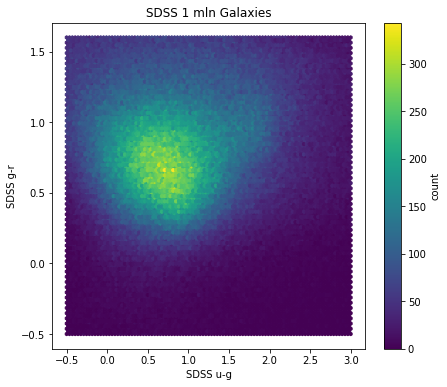

In [21]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(7,6))
img = ax.hexbin(u-g , g-r , extent=(-0.5,3,-0.5, 1.6))
ax.set_title('SDSS 1 mln Galaxies')
ax.set_xlabel('SDSS u-g')
ax.set_ylabel('SDSS g-r')
plt.colorbar(img, label='count')

In a similar fashion, select stars, requiring OBJC_TYPE == 6 , and limit output to 1 mln rows  : 

In [10]:
%%time
# select stars,  
# ensure non-negative fluxes ...
sdsst = sdss.select(['u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 6).\
    where((sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0) ).\
    limit(1000000).toPandas()

# convert to mags ...
u =  -2.5 * np.log10(sdsst['u']) + 22.5
g =  -2.5 * np.log10(sdsst['g']) + 22.5
r =  -2.5 * np.log10(sdsst['r']) + 22.5


CPU times: user 19.9 s, sys: 6.22 s, total: 26.1 s
Wall time: 14.1 s


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
fig,ax = plt.subplots(1,1,figsize=(7,6))
img = ax.hexbin(u-g , g-r , extent=(-0.5,3,-0.5, 1.6))
ax.set_title('SDSS 1 mln Stars')
ax.set_xlabel('SDSS u-g')
ax.set_ylabel('SDSS g-r')
plt.colorbar(img, label='count')



NameError: name 'plt' is not defined

Looks pretty!  Exactly what I'd expect from a stellar locus.  

### Select subset of the SDSS table for crossmatching <a id='selectsdss'></a>

There are billions of stars in the SDSS catalog - we may want to skip the very faint ones. Also, since there may be some more unreliable photometry at the faint end, we will need to select stars brighter than eg. 22.5 mag in g ... 

To do that need to use  a pyspark function  `sparklog10` to convert fluxes to magnitudes on-the-fly.  

First lets find out how many stars there are, by applying `.where().count()` statement (instead of `.select().where()`): 

In [12]:
%%time

from pyspark.sql.functions import log10 as sparklog10
limitMag = 20 
a = sdss.where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
          ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag)).count()
print(a)

98735687
CPU times: user 9.85 ms, sys: 9.68 ms, total: 19.5 ms
Wall time: 32.8 s


Select rows from the SDSS table for cross-matching:

In [13]:
%%time 

from pyspark.sql.functions import log10 as sparklog10
limitMag = 20 
sdss_sel = sdss.select(['zone', 'RA', 'DEC', 'u','g','r','i',
                        'uErr','gErr', 'rErr', 'iErr', 'dup']).\
    where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
    ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag))

CPU times: user 10.7 ms, sys: 2.85 ms, total: 13.6 ms
Wall time: 172 ms


### Select subset of  ZTF ... <a id='selectztf'></a>

Now since `ztf_1am_lc` contains all filters, we need to cross-match filter-by-filter.  To select all rows that pertain to a given filterid,  use an `array_contains` function. 

First select only rows with over 100 good observations (so that the averaged quantities have good statistics), and  keep the first 1000 rows for inspection as pandas Data Frame : 

In [14]:
%%time
ztf_lct = ztf_lc.select(['matchid', 'ra', 'dec', 'zone', 'dup', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag',
'nbestobs', 'ngoodobs', 'nobs','bestmedianmag', 'filterid', 'mag','mjd']).\
  where(ztf_lc['ngoodobs']>100).\
    limit(1000).toPandas()

In [17]:
ztf_lct[:3]

,matchid,ra,dec,zone,dup,bestmagrms,bestmeanmag,bestmedianmag,medianmag,meanmag,nbestobs,ngoodobs,nobs,bestmedianmag,filterid,mag,mjd
0,000587120310519,263.233187,19.834015,6589,1,0.191403,17.440641,17.411692,17.412697,17.449076,105,111,111,17.411692,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17.420259475708008, 17.375978469848633, 17.35...","[58208.4886458, 58235.4001505, 58237.3199306, ..."
1,000587120320856,263.233190,19.834018,6589,1,0.150033,16.807577,16.784302,16.785053,16.828259,84,106,106,16.784302,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[16.700441360473633, 16.63174819946289, 16.996...","[58262.3777315, 58302.2941898, 58304.3754398, ..."
2,000587120310513,263.241114,19.834610,6589,1,0.035411,18.067976,18.071440,18.071440,18.067839,152,160,160,18.071440,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[18.1038875579834, 18.05986785888672, 18.07690...","[58275.2739699, 58278.3941667, 58281.3814352, ..."


Indeed, we see that each row has either observations taken exclusively either in filterid=1 (g), filterid=2 (r), or filterid=3 (i).

Another example : we can count how many rows there are with a given constraint (eg. more than 10 good observations, in ZTFg) : 

In [32]:
%%time 
# 
from pyspark.sql.functions import array_contains
# Use this function to select only rows that have 
# a  given filterid 

a = ztf_lc.where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], 1))).count()
print(a)

48301066
CPU times: user 72.2 ms, sys: 20.9 ms, total: 93.1 ms
Wall time: 6min 15s


 Finally, ensure that for crossmatching  there are no columns with duplicate names between SDSS and ZTF  (`zone` and `dup` are always required, and are handled internally by AXS). 

    ZTF : 'zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs'
            
    SDSS : 'zone','dup', 'RA', 'DEC', 'u','g','r','i',
            'uErr','gErr', 'rErr', 'iErr', 
        


###  ZTF-SDSS crossmatching  <a id='crossmatch'></a>

Crossmatch ZTF fid=1 (2,3), i.e. 	ZTF g, ZTF r, ZTF i,   to SDSS with matching radius of 2 arcsec : 

In [ ]:
%%time

from axs import Constants
from pyspark.sql.functions import array_contains

# Loop over fid = 1,2,3 .... 

for fid in [1,2,3] : 
    ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], fid)))
        
    print('Crossmatching ZTF fid=%d to SDSS stars  g < %.2f...'%(fid, limitMag))
    fname = "ztf_fid"+str(fid)+"_sdss_stars_lt"+str(limitMag)+"_2asec"
    print('Saving to ', fname)

    
    crossmatch = ztf_lc_fid.\
        crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
        save_axs_table(fname)
    

The result of this crossmatching can be inspected : 

In [18]:
sdss_ztfg = axs_catalog.load('ztf_fid1_sdss_stars_lt20_2asec')

In [22]:
np.ravel(sdss_ztfg.columns)

array(['zone', 'dup', 'matchid', 'bestmagrms', 'bestmeanmag',
       'bestmedianmag', 'medianmag', 'meanmag', 'nbestobs', 'ngoodobs',
       'u', 'g', 'r', 'i', 'uErr', 'gErr', 'rErr', 'iErr', 'axsdist',
       'ra', 'dec'], dtype='<U13')

In [27]:
sdss_ztfgt = sdss_ztfg.select(['matchid', 'bestmedianmag', 'u','g','r','i','ra','dec']).\
             limit(10000).toPandas()

In [28]:
sdss_ztfgt[:3]

,matchid,bestmedianmag,u,g,r,i,ra,dec
0,00057912031122,19.818748,2.176900,11.446885,22.849567,30.775221,205.085932,19.828893
1,000579120310272,17.249290,20.169413,115.192566,227.870697,284.796539,205.229231,19.829647
2,000579120310271,18.379879,17.708698,42.649181,53.779533,60.433449,205.296017,19.831281


Note that still, `u` , `g`, `r` are SDSS fluxes . So let's transform them to magnitudes: 



In [29]:
for f in 'ugri':
    sdss_ztfgt[f+'mag'] =  -2.5 * np.log10(sdss_ztfgt[f]) + 22.5

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


For example, show the offset between ZTFg and SDSSg : 

Text(0,0.5,'SDSS g  - ZTF g (median)')

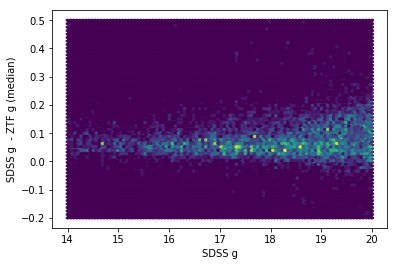

In [35]:
%matplotlib inline
plt.hexbin(sdss_ztfgt['gmag'], sdss_ztfgt['gmag'] - sdss_ztfgt['bestmedianmag'],
          extent=[14,20,-0.2,0.5])
plt.xlabel('SDSS g')
plt.ylabel('SDSS g  - ZTF g (median)')

More of that in a separate notebook `ZTF_SDSS_offsets`, also available on https://github.com/suberlak/epyc-notebooks/blob/master/ZTF_SDSS_offsets.ipynb

### Everything in one place - minimal working example <a id='tldr'></a>

In [49]:
###  Minimal working example : crossmatch ZTF LC to SDSS ####
    
from axs import Constants
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import log10 as sparklog10
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
import pyspark

spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
     
axs_catalog = AxsCatalog(spark)

ztf_lc = axs_catalog.load("ztf_1am_lc")
sdss = axs_catalog.load("sdss_zoned1am_hd")


# select SDSS stars ... 
limitMag = 20 
sdss_sel = sdss.select(['zone', 'RA', 'DEC', 'u','g','r','i',
                        'uErr','gErr', 'rErr', 'iErr', 'dup']).\
    where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
    ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag))
    


# select ZTF obs in a given filter, with over 10 good obs ...
for fid in [1,2 ,3 ]
    ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
                   'bestmagrms', 'bestmeanmag', 'bestmedianmag',
                   'medianmag','meanmag','nbestobs', 'ngoodobs']).\
          where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], fid)))

    # crossmatch 
    print('Crossmatching ZTF fid=%d to SDSS stars  g < %.2f...'%(fid, limitMag))
    fname = "ztf_fid"+str(fid)+"_sdss_stars_lt"+str(limitMag)+"_2asec"
    print('Saving to ', fname)

    crossmatch = ztf_lc_fid.\
        crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
        save_axs_table(fname)